## Task6 Different Optimizers 
#### The following contents refer some parts from <a href="http://cs231n.github.io/neural-networks-3/">CS231n</a>

- Once the analytic gradient is computed with backpropagation, the gradients are used to perform a parameter update. There are several approaches for performing the update

#### Vanilla Update 
- The simplest form of update is to change the parameters along the negative gradient direction 

$$ x += -lr * dx$$

#### Momentum update 
- This update can be motivated from a physical perspective of the optimization problem.
- The loss can be interpreted as the <strong> height of a hilly terrain</strong>. Initializing the parameters with random numbers is equivalent to setting a particle with zero initial velocity at some location. The optimization process can then be seen as equivalent to the process of simulating the parameter vector (i.e. a particle) as rolling on the landscape.

$$ v = \mu v - lr * dx $$
$$ x = x + v $$

- A typical setting is to start with momentum of about 0.5 and anneal it to 0.99 or so over multiple epochs.

#### Nesterov Momentum 
- Nesterov Momentum is a slightly different version of the momentum update that has recently been gaining popularity. It enjoys stronger <strong> theoretical converge guarantees for convex functions</strong> and in practice it also consistenly works slightly better than standard momentum.

$$ ahead = x + mu * v $$

$$ v = mu * v - lr * dxahead $$
$$ x += v $$

###  Per-parameter adaptive learning rate methods

#### Adagrad 

$$ cache += dx**2 $$
$$ x += - lr * dx / (np.sqrt(cache) + eps) $$

- cache has size equal to the size of gradient, eps is the smoothing term

- <strong> Adaptive Gradient Algorithm</strong> (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

#### RMSprop

$$ cache = decay * cache + (1 - decay) * dx**2 $$
$$ x += - lr * dx / (np.sqrt(cache) + eps) $$

- decay is a hyperparameter and typical values are 0.9 0.99 or 0.999
- <strong> Root Mean Square Propagation</strong> (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

#### Adam


$$ m = beta1*m + (1-beta1)*dx $$
$$ v = beta2*v + (1-beta2)*(dx**2) $$
$$ x += - lr * m / (np.sqrt(v) + eps) $$
- The following conclusions are from <a href="https://arxiv.org/abs/1412.6980">arXiv.org</a>
- Adam realizes the benefits of both AdaGrad and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).
- Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.
- The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [6]:
N, D_in, H, D_out = 64, 1000, 100, 10

In [7]:
model = TwoLayerNet(D_in, H, D_out)
print(model)

TwoLayerNet(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

### TRAIN

In [45]:
# define differnt optimizer
op1_SGD = TwoLayerNet(D_in, H, D_out)
op2_Mom = TwoLayerNet(D_in, H, D_out)
op3_RMSprop = TwoLayerNet(D_in, H, D_out)
op4_ADAM = TwoLayerNet(D_in, H, D_out)
# list for iteration  models
models = [op1_SGD, op2_Mom, op3_RMSprop, op4_ADAM]

twolayernet_SGD = optim.SGD(op1_SGD.parameters(), lr = 1e-4)
twolayernet_Mom = optim.SGD(op2_Mom.parameters(), lr = 1e-4, momentum = 0.8)
twolayernet_RMSprop = optim.RMSprop(op3_RMSprop.parameters(), lr = 1e-4, alpha=0.9)
twolayernet_Adam = optim.Adam(op4_ADAM.parameters(), lr = 1e-4,  betas=(0.9, 0.99))
# list of optimizers 
optimizers = [twolayernet_SGD, twolayernet_Mom, twolayernet_RMSprop, twolayernet_Adam]

# loss 
loss_fn = torch.nn.MSELoss(reduction='sum')
loss_all = [[], [], [], []]

In [46]:
for t in range(100):
    # Forward pass: Compute predicted y by passing x to the model  
    for model, op, loss_one in zip(models, optimizers, loss_all):
        y_pred = model(x)

        # Compute and print loss
        loss = loss_fn(y_pred, y)

        # Zero gradients, perform a backward pass, and update the weights.
        op.zero_grad()
        loss.backward()
        op.step()
        loss_one.append(loss.item())

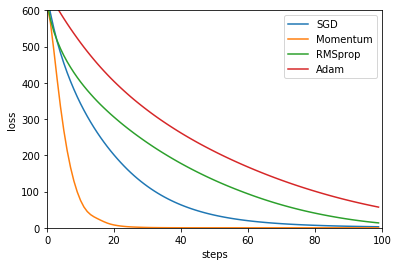

In [50]:
# plot lossdata:image/png;base64,+//eCCO4PXXtbwbIu4urqWlbdXQsuiq6IKCqgYgEEEUSq9CIIwYQWSCBAQtrM+f0xN2PKJISEkEw4n+fJk7nvfe++qrpTRJoDc1W1vYi86byeVDxflRTQGGNMmUKq8NxtgT3AOyLSDVgG3As0LfjQd4JEEyd/SyC50PEpTlqRACEiI/HVMIh2u3uckphY5KJZeVlsPbCVuPpx1A2te++gLHbaVrC+Z1aKH//westsilORUQtQhhjTKVUZRMTwN3ARBEJA7YAw/EFpY9E5FbgN+BqJ+8MYBCwGchy8h6ZxwNu9zEutjHGmCoNEKq6AugZYFe/AHkVuPOor+HxlNJ5YTUIY2qavLw8UlJSyM7Oru6inBDq1KlDq1atCA0NrdDxVV2DqHLqKdbE5PRB2HMujKl5UlJSiIqKIi4u7vf+QlMlVJW0tDRSUlJo06ZNhc4R/EttePKLbFofhDE1V3Z2NrGxsRYcjgMRITY2tlK1taAPEFpKJ7Uxpmay4HD8VPZeB32AwOOp7hIYY0ytFPQBQosFCOuDMMYcydNPP03nzp3p2rUriYmJLFq0iPz8fB599FHi4+NJTEwkMTGRp59+2n+M2+0mMTGRzp07061bN1566SW8xVowapug76QuXoOwPghjTFkWLlzIF198wfLlywkPD2fv3r3k5uby+OOPs2vXLlavXk2dOnU4ePAgL774ov+4iIgIVqxYAUBqaio33HADGRkZPPnkk9X1Vqpc0AeI4jWIgi4Iq0EYYwLZuXMnjRo1Ijw8HIBGjRqRlZXFW2+9RVJSEnXq1AEgKiqKMWPGBDxHkyZNGDduHL169WLMmDG1tl8l6ANEaTUIY0zN9uTna1m348AxPWenFvX568Wdy8zTv39/xo4dS7t27bjgggu49tpradiwISeddBJRUVHlvlbbtm3xer2kpqbStGnTyha9Rqp1fRD+dGtiMsYEUK9ePZYtW8a4ceNo3Lgx1157LXPnzi2S55133iExMZHWrVuTnJwc+ETU/paKoK9BlOiktj4IY4LCkb7pVyW3203fvn3p27cvXbp04c033+S3337j4MGDREVFMXz4cIYPH05CQgKeUr6EbtmyBbfbTZMmTQLurw2CvgZRYrE+W83VGFOGjRs3smnTJv/2ihUraN++Pbfeeit33XWXf2KZx+MhNzc34Dn27NnD7bffzl133VVr+x+gNtQg8q0PwhhTfocOHeLuu+9m//79hISE8Ic//IFx48bRoEED/vKXv5CQkEBUVBQREREMGzaMFi1aAHD48GESExPJy8sjJCSEoUOH8sADD1Tzu6laQR8g8FofhDGm/Hr06MGPP/4YcN+zzz7Ls88+G3BfaU1NtVnQNzEVr0H40y1AGGNMpQR9gCheg7CZ1MYYc2wEfYAorQ/CahDGGFM5QR8gStQgrJPaGGOOiaAPEMUfGORPtxqEMcZUSi0IEMUeGGTzIIwx5pgI+gBRYqKc9UEYY8ogIgwdOtS/nZ+fT+PGjRkyZEi1lGfFihXMmDGjWq59JEEfIDS/aA3CuiCMMWWpW7cua9as4fDhwwDMnDmTli1bVlt5LEBUpVIe2GHDXI0xpRk4cCBffvklAJMmTeL666/370tPT+eyyy6ja9eu9O7dm1WrVgEwZswYhg0bRv/+/YmLi+PTTz/l4YcfpkuXLgwYMIC8vDwAli1bxrnnnkuPHj246KKL2LlzJwB9+/Zl1KhRnHbaabRr144ffviB3NxcnnjiCSZPnkxiYiKTJ09mzJgxvPDCC/7yJCQkkJSURFJSEh06dOCPf/wjCQkJ3HjjjcyaNYszzzyT+Ph4Fi9efMzvU9DPpLZhrsYEqa9Gw67Vx/aczbrAwMAzoQu77rrrGDt2LEOGDGHVqlWMGDGCH374AYC//vWvnHrqqUydOpXvvvuOm2++2f+goF9//ZU5c+awbt06+vTpwyeffMI//vEPLr/8cr788ksGDx7M3XffzbRp02jcuDGTJ0/mscce4+233wZ8zVmLFy9mxowZPPnkk8yaNYuxY8eydOlS/v3vfwOU+gwKgM2bN/Pxxx/7n0XxwQcfMH/+fKZPn84zzzzD1KlTK3kDiwr6AFHaMFcLEMaY0nTt2pWkpCQmTZrEoEGDiuybP38+n3zyCQDnn38+aWlpZGRkAL6aR2hoKF26dMHj8TBgwAAAunTpQlJSEhs3bmTNmjVceOGFgG95jubNm/vPfcUVVwC+5T6SkpKOutxt2rShS5cuAHTu3Jl+/fohIv7rH2tBHyCKD3O1mdTGBIlyfNOvSpdccgkPPfQQc+fOJS0tzZ8e6LOj4HOl4Cl0LpeL0NBQf7rL5SI/Px9VpXPnzixcuDDgNQuOd7vd5BfvP3WEhIQUedZ1weqyhY8vuGbh8pR2vsoI/j6I4sNcrZfaGFMOI0aM4IknnvB/Iy9wzjnnMHHiRADmzp1Lo0aNqF+/frnO2b59e/bs2eMPEHl5eaxdu7bMY6Kiojh48KB/Oy4ujuXLlwOwfPlytm7dWu73dKwFfYAobaKcMcaUpVWrVtx7770l0seMGcPSpUvp2rUro0eP5t133y33OcPCwpgyZQqjRo2iW7duJCYmlrpybIHzzjuPdevW+Tupr7zyStLT00lMTOT111+nXbt2R/3ejhWpyqYYEUkCDgIeIF9Ve4pIDDAZiAOSgGtUdZ/46mqvAIOALOAWVV1e1vkT6kTovLfHE3PDDf605APJDPpsEE+f9TSXnHJJFbwrY0xFrV+/no4dO1Z3MU4oge65iCxT1Z5HOvZ41CDOU9XEQoUZDcxW1XhgtrMNMBCId35GAq+X6+zFaxAFE6mtD8IYYyqlOpqYLgUK6mzvApcVSn9PfX4CokWkeaATFFZiqQ3rgzDGmGOiqgOEAt+KyDIRGemkNVXVnQDO74InfrcEkgsdm+Kklc0W6zPGmCpR1cNcz1TVHSLSBJgpIhvKyBvoq3+JT3kn0IwE6BxeB7UHBhljTJWo0hqEqu5wfqcCnwGnAbsLmo6c36lO9hSgdaHDWwE7ApxznKr29PdpeOx5EMYYUxWqLECISF0RiSp4DfQH1gDTgWFOtmHANOf1dOBm8ekNZBQ0RZVFSwkQ1sRkjDGVU5U1iKbAfBFZCSwGvlTVr4FngQtFZBNwobMNMAPYAmwG3gLuKNdVigcIsRqEMaZ0brebxMREEhISuPjii9m/fz8ASUlJiAh/+ctf/Hn37t1LaGgod911FwAbN26kb9++JCYm0rFjR0aOHBnwGrVFlQUIVd2iqt2cn86q+rSTnqaq/VQ13vmd7qSrqt6pqqeoahdVXXrEi0gZT5SzPghjTAARERGsWLGCNWvWEBMTw3/+8x//vrZt2/LFF1/4tz/++GM6d+7s377nnnu4//77WbFiBevXr+fuu+8u93VVtcgSGsEguGdSi5RYaqOANTEZY46kT58+bN++3b8dERFBx44dWbrU9/108uTJXHPNNf79O3fupFWrVv7tgmU6JkyYwKWXXsqAAQNo3749Tz75JOCrlXTs2JE77riD7t27k5yczKRJk+jSpQsJCQmMGjXKf6569erx4IMP0r17d/r168eePXuq9L2XR5Av1iclF+uzPghjgsJzi59jQ3pZAxuPXoeYDow6bdSRM+JbaXX27NnceuutRdKvu+46PvzwQ5o1a4bb7aZFixbs2OEbL3P//fdz/vnnc8YZZ9C/f3+GDx9OdHQ0AIsXL2bNmjVERkbSq1cvBg8eTKNGjdi4cSPvvPMOr732Gjt27GDUqFEsW7aMhg0b0r9/f6ZOncpll11GZmYm3bt358UXX2Ts2LE8+eST/iXAq0uQ1yAoudy39UEYY8pw+PBhEhMTiY2NJT093b80d4EBAwYwc+ZMJk2axLXXXltk3/Dhw1m/fj1XX301c+fOpXfv3uTk5ABw4YUXEhsbS0REBFdccQXz588H4OSTT6Z3794ALFmyhL59+9K4cWNCQkK48cYbmTdvHuBbkbXgejfddJP/+OoU/DWIYg8MKmB9EMbUbOX9pn+sFfRBZGRkMGTIEP7zn/9wzz33+PeHhYXRo0cPXnzxRdauXcvnn39e5PgWLVowYsQIRowYQUJCAmvWrAFKfjkt2K5bt64/7Wg+l2rCl92gr0GUmChn8yCMMeXQoEEDXn31VV544QX/40ILPPjggzz33HPExsYWSf/666/9eXft2kVaWpr/edYzZ84kPT2dw4cPM3XqVM4888wS1zz99NP5/vvv2bt3Lx6Ph0mTJnHuuecC4PV6mTJlCgAffPABZ5111jF/z0cruGsQIlD8kaM2k9oYU06nnnoq3bp148MPP+Tss8/2p3fu3LnI6KUC3377Lffeey916tQB4Pnnn6dZs2YAnHXWWQwdOpTNmzdzww030LNnzxJPeWvevDl///vfOe+881BVBg0axKWXXgr4ahpr166lR48eNGjQgMmTJ1fRuy6/Kl3uu6p1iYrSb+65hxZPP+1P23t4L+d9dB6Pn/4413a4toyjjTHHW21d7nvChAlFnitdEfXq1ePQoUPHsFQ+NX2576oToAZRwEYxGWNM5QR3ExOCem2YqzGmet1yyy3ccsstlTpHVdQeKivIaxCUutRGMDedGWNMTRDkAUJssT5jjKkiwR0goOREORvmaowxx0RwBwgpfaKcMcaYygnuAIHYE+WMMUfts88+Q0TYsCHwWlC33HKLf9LaiSy4A4Rgw1yNMUdt0qRJnHXWWXz44YfVXZQaLagDhEjpNQhjjAnk0KFDLFiwgPHjx/sDhKpy11130alTJwYPHkxqaqo//9ixY+nVqxcJCQmMHDnS3zrRt29f7r//fs455xw6duzIkiVLuOKKK4iPj+fxxx+vlvd2rAX5PAjAHhhkTFDa9cwz5Kw/tst9h3fsQLNHHy0zz9SpUxkwYADt2rUjJiaG5cuXk5SUxMaNG1m9ejW7d++mU6dOjBgxAoC77rqLJ554AoChQ4fyxRdfcPHFFwO+hf3mzZvHK6+8wqWXXsqyZcuIiYnhlFNO4f777y+xllOwCeoahA1zNcYcrUmTJnHdddcBvmc/TJo0iXnz5nH99df7n/9w/vnn+/PPmTOH008/nS5duvDdd9+xdu1a/75LLrkE8D04qHPnzjRv3pzw8HDatm1LcnLy8X1jVaAW1CBsmKsxwehI3/SrQlpaGt999x1r1qxBRPB4PIgIl19+ecDm6ezsbO644w6WLl1K69atGTNmDNnZ2f794eHhgO9ZDgWvC7bz8wM/7TKY1L4ahI1iMsaUYsqUKdx8881s27aNpKQkkpOTadOmDTExMXz44Yd4PB527tzJnDlzAPzBoFGjRhw6dOiEG9kU5DUIsRqEMabcJk2axOjRo4ukXXnllaxfv574+Hi6dOlCu3bt/M9oiI6O5v/+7//o0qULcXFx9OrVqzqKXW2Cernvrk2a6NQ+Z9B22lR/WlZeFqd/cDoP9HiA4QnDq7F0xpjiauty3zXZib3ct9fmQRhjTFUI7gABaLFhrtYHYYwxx0ZQBwgRQT1FRwpYH4QxNZt9eTt+KnuvgzpAAKVPlLMmJmNqnDp16pCWlmZB4jhQVdLS0vzPz66I4B7FVMYwV2NMzdOqVStSUlLYs2dPdRflhFCnTh1atWpV4eODPkCUNszVvqEYU/OEhobSpk2b6i6GKacqb2ISEbeI/CwiXzjbbURkkYhsEpHJIhLmpIc725ud/XHlOb8ttWGMMVXjePRB3AusL7T9HPBPVY0H9gG3Oum3AvtU9Q/AP518ZQtQg7A+amOMOTaqNECISCtgMPBfZ1uA84GC+ervApc5ry91tnH295NydCio11ZzNcaYqlDVNYiXgYeBgk/xWGC/qhaMTU0BWjqvWwLJAM7+DCd/ESIyUkSWisjSw9nZkB94mKs1MRljTOVUWYAQkSFAqqouK5wcIKuWY9/vCarjVLWnqvaMiIgoUYOwAGGMMcdGVY5iOhO4REQGAXWA+vhqFNEiEuLUEloBO5z8KUBrIEVEQoAGQHpZFxAb5mqMMVWmymoQqvqIqrZS1TjgOuA7Vb0RmANc5WQbBkxzXk93tnH2f6dH6kgI1EntL0BlSm+MMaY6ZlKPAh4Qkc34+hjGO+njgVgn/QFgdCnHF+X1FumQtiYmY4w5No7LRDlVnQvMdV5vAU4LkCcbuPqoTlzQnOTxQEiIk2QBwhhjjoXgX4uJkpPlwIa5GmNMZQV3gChcgyicbLPljDGm0oI7QBT0NwSYLGdNTMYYUznBHSAKKgrFJ8uJWBOTMcZUUpAHiMA1CGtiMsaYygvqAOEf0lqsBhHiCiHfmx/oEGOMMeUU1AHCX1EoVoMIc4WR6809/uUxxphaJLgDhL8GUXQUU6g7lFyPBQhjjKmM4A4Q/hpE0QAR5g6zAGGMMZUU5AHCqUEUmwcR7g63AGGMMZUU3AGiQLEAEeoKtT4IY4yppOAOEP4aRLFOamtiMsaYSgvqAOF/9oOn6JBWG8VkjDGVF9QBokCgGkSeJ6+aSmOMMbVDcAeIUmoQNszVGGMqL7gDhKP4UhvhrnByvDnVVBpjjKkdgjtAlLLctzUxGWNM5QV3gHAUnwdho5iMMabygjtAlDJRzuZBGGNM5dWKABGoiclqEMYYUznBHSAcgZbayPNaH4QxxlRGUAcIKaUGEeoKJcdjo5iMMaYygjpAFAg0Uc6rXntokDHGVEJwB4iCGkSA5b4B64cwxphKKFeAEJF7RaS++IwXkeUi0r+qC1dexR8YFObyBQjrhzDGmIorbw1ihKoeAPoDjYHhwLNVVqryshqEMcZUmfIGiIJntw0C3lHVlYXSqo8EfuRoQYCwjmpjjKm48gaIZSLyLb4A8Y2IRAHesg4QkToislhEVorIWhF50klvIyKLRGSTiEwWkTAnPdzZ3uzsjyvvm9DiNQinickmyxljTMWVN0DcCowGeqlqFhCKr5mpLDnA+araDUgEBohIb+A54J+qGg/sc85dcI19qvoH4J9OvrKVMVEOsPWYjDGmEsobIPoAG1V1v4jcBDwOZJR1gPoccjZDnR8FzgemOOnvApc5ry91tnH29xP/RIeyBVqLCawPwhhjKqO8AeJ1IEtEugEPA9uA9450kIi4RWQFkArMBH4F9qtqwQSFFKCl87olkAzg7M8AYgOcc6SILBWRpWnp6b7EYvMgQl2hgDUxGWNMZZQ3QOSrquL7lv+Kqr4CRB3pIFX1qGoi0Ao4DegYKJvzO1BtQUskqI5T1Z6q2rNRo0a+tABLbYDVIIwxpjLKGyAOisgjwFDgSxFx42syKhdV3Q/MBXoD0SIS4uxqBexwXqcArQGc/Q2A9HJdwIa5GmPMMVfeAHEtvk7nEaq6C19z0PNlHSAijUUk2nkdAVwArAfmAFc52YYB05zX051tnP3fObWWsi4ClBzmak1MxhhTeeUKEE5QmAg0EJEhQLaqHqkPojkwR0RWAUuAmar6BTAKeEBENuPrYxjv5B8PxDrpD+AbNVU+VoMwxphjLuTIWUBErsFXY5iLr6/gXyLyZ1WdUtoxqroKODVA+hZ8/RHF07OBq8tXbH/BfMeWMlHOAoQxxlRcuQIE8Bi+ORCp4Gs+Ambx+3DV6uNylZgoV9BJbWsxGWNMxZW3D8JVEBwcaUdxbNVyu0sd5mpLbRhjTMWVtwbxtYh8A0xytq8FZlRNkY6OuN2op+hzH6yJyRhjKq9cAUJV/ywiVwJn4uuDGKeqn1VpycpJXK4SNQhbi8kYYyqvvDUIVPUT4JMqLEvFhISUmCjndrlxi9vWYjLGmEooM0CIyEECzGbGV4tQVa1fJaU6Cr4ahKdEepg7zJqYjDGmEsoMEKp6xOU0ql2AGgQ4AcKamIwxpsJqxkikShCXq8REOfD1Q1gNwhhjKi7oAwRuN+op+ewia2IyxpjKCfoAIW43FBvmCr65ENbEZIwxFRf0AQK3y2oQxhhTBYI+QIg7pMREOfAtt2E1CGOMqbhaECBKTpQDp4nJahDGGFNhQR8gcJcxzNUChDHGVFjQBwibKGeMMVUj6AMEISEllvsG3zwIW+7bGGMqLugDhLhckG81CGOMOdaCPkDgdqPeUoa52igmY4ypsKAPEOJ2Q37JYa621IYxxlRO0AcI3K7SaxAWIIwxpsKCPkCUNlEu1G3zIIwxpjKCPkBQykS5MJevD0I10OMsjDHGHEnQBwhxBx7mGu4OByDfW7J2YYwx5shqQYAofZgrQI4n53gXyRhjaoWgDxC43AFrEKGuUAAb6mqMMRUU9AHCN8y19BqEdVQbY0zFBH2AKGuiHECex5bbMMaYiqiyACEirUVkjoisF5G1InKvkx4jIjNFZJPzu6GTLiLyqohsFpFVItK9XNcpbaJcQQ3CmpiMMaZCqrIGkQ88qKodgd7AnSLSCRgNzFbVeGC2sw0wEIh3fkYCr5frKqVNlHNZE5MxxlRGlQUIVd2pqsud1weB9UBL4FLgXSfbu8BlzutLgffU5ycgWkSaH+k64g4pdblvsFFMxhhTUcelD0JE4oBTgUVAU1XdCb4gAjRxsrUEkgsdluKkFT/XSBFZKiJL9+zZ4zyTOvBy34At+W2MMRVU5QFCROoBnwD3qeqBsrIGSCsxDVpVx6lqT1Xt2bhxY8TlLrMGYU1MxhhTMVUaIEQkFF9wmKiqnzrJuwuajpzfqU56CtC60OGtgB1HvEaIO2ANItTtzIOwAGGMMRVSlaOYBBgPrFfVlwrtmg4Mc14PA6YVSr/ZGc3UG8goaIoqkyvwMNdwl2+pDRvFZIwxFRNShec+ExgKrBaRFU7ao8CzwEcicivwG3C1s28GMAjYDGQBw8tzEQk5wjBXq0EYY0yFVFmAUNX5BO5XAOgXIL8Cdx71hUqpQViAMMaYygn6mdTiDtxJbWsxGWNM5QR9gMDtAtUStQirQRhjTOUEfYAQt9NKVqwWUfA8CJsHYYwxFRP0AQK37y0UH+rqb2KyGoQxxlRI0AcIcbkB0GJLfosIoa5QW2rDGGMqKOgDhKtuJADerMwS+8LcYVaDMMaYCgr6AOGObgiAZ9/+EvvCXGHWB2GMMRUU/AEipiBA7Cuxz2oQxhhTcUEfIEIaFgSI9BL7wtxhNg/CGGMqKOgDhNsJEPmBahAuq0EYY0xFBX+AiI4GwJNuTUzGGHMsBX2AkJAQXA0aBOyDCHWHWoAwxpgKCvoAARASHR0wQES4I8jKz6qGEhljTPCrFQHCHRNDfoBO6kaRjdh7eG81lMgYY4Jf7QgQDRsGnAfRJLIJqVmp+FYSN8YYczRqSYAI3MTUNLIped489uWU3GeMMaZstSJAhMTE4ElPL1FTaBLZBIDUrNRAhxljjClDrQgQ7uiGaF4e3syiHdIWIIwxpuJqR4AomE29v2hTUtPIpgDsztp93MtkjDHBrnYEiIL1mNKLjmSKjYhFEKtBGGNMBdSKAPH7ekxFaxChrlBiI2ItQBhjTAXUigBR1npMTSKbWBOTMcZUQK0KEIHWYyqYC2GMMebo1IoA4apXD0JDS50LYQHCGGOOXq0IECLiW49pf+AaREZOBtn52dVQMmOMCV61IkCAr5kpv5QmJoA9WXuOd5GMMSao1Z4AERMTsImpIEBYR7UxxhydKgsQIvK2iKSKyJpCaTEiMlNENjm/GzrpIiKvishmEVklIt2P9nruhtEl5kHA75PlrB/CGGOOTlXWICYAA4qljQZmq2o8MNvZBhgIxDs/I4HXj/ZiIQ0bllmDsABhjDFHp8oChKrOA4p/pb8UeNd5/S5wWaH099TnJyBaRJofzfXcDWPwHDiA5ucXSa8XWo+IkAhrYjLGmKN0vPsgmqrqTgDndxMnvSWQXChfipNWbu6GDUEVT0ZGkXQRsaGuxhhTATWlk1oCpAV8yo+IjBSRpSKydM+e30cmuRtGAyWX2wCbLGeMMRVxvAPE7oKmI+d3wad2CtC6UL5WwI5AJ1DVcaraU1V7Nm7c2J8eEhMDQH6AjmoLEMYYc/SOd4CYDgxzXg8DphVKv9kZzdQbyChoiiqvsLZtwe3m4KxZJfY1q9uM1KxU8jx5lSi6McacWKpymOskYCHQXkRSRORW4FngQhHZBFzobAPMALYAm4G3gDuO9nqhTZvSYMgQ9n/0MflpaUX2dYzpSL7msyF9Q8XfkDHGnGCqchTT9araXFVDVbWVqo5X1TRV7aeq8c7vdCevquqdqnqKqnZR1aUVuWbsbSPRnBzS332vSHq3xt0AWLlnZWXfljHGnDBqSif1MRHeti1R/fuz74MP8Bw44E9vWrcpTSObsmrPqmosnSlLUkYSC7YvqO5iBI0VqStYsmtJdRfD1HK1KkAANLr9NryHDrH/4ylF0rs17mY1iBoq35vPPXPu4Y7Zd7A+bX11F+eY8aqXl5e9zKKdi475uZ/66SnGLhxbZp6DuQfJyssqM48xZal1AaJOx46Ex8eTuXBhkfRujbuxI3OHLdqlbN7EAAAbdklEQVRXQfnefL7a+hXDvhrGxPUTj+m5P9v8GVszthLqCuWpn57C4/UU2a8acMTzMffTzp/406w/HbMgtXDHQsavGc/tM2/n818/r9S5vOr1v87IyWDTvk1sO7CtzABw28zbuH/u/ZW6rjmxhVR3AapCRM8eHJj+OerxIG43AN2a/N4PccHJF1Rn8cot15PLS8teYnfmbp4880nqh9U/rtdPPpjMayteIzUrlaQDSaRmpRIZEsmKPSs4JfoUejfvXelrZOVl8dqK10hsnMg17a/h0fmP8uHGD2nXsB3zt89nReoK1qev54YON3Bfj/uOwbsqKSMng2cWPcOMrTMAyPHk8PZFbxfJk+fNI/lAMm2j2/q375x1JxecfAHXtL/m93yePELdoQBM+WUKDcMbEt8wnkfnP8r+nP0M7TT0qMuXfCCZK6ZfwWsXvEavZr1YkboCdaYJ/bLvFxKbJJY4ZlfmLlbvXQ34mu/iGsSVyONVL7d8fQudYzsz6rRRAHi8HrYd2OZ/n+bEVutqEACRPXrizcwke8Pvo5Y6xnQk1BUaNM1MuzN3M/yb4UxcP5G5yXMZ9tUwdh46qpG/APy4/ccic0A+//VzXlr2Urm+lb+z5h2+TvqaXE8uiY0Tebnvy8y+ejZt6rfh4e8fZuehneR6csn35h/xXKV5d9277D28lwd7PsiQtkM4vdnpPLv4WUZ8M4L31r1Hvjeftg3a8t6699hxyDc1JiMng4U7fq8herweXl/xOmvT1pY4v6qyO7P0ZVYO5h7ktpm38e22b7m92+3c3+N+luxaUqJZ6KmFT3HZtMv8I+G+++07Fu5cyN8X/51f9v2CV738ZcFf6PdxP1IOprD38F7mJs/lsj9cxusXvM6FJ1/IP5b8g+m/Tj/iPTmUe4i9h/f6t+dtn0e2J5tpm32jwpftXoZLfH+669LWBTzHvJR5AAjCp5s+BXzBePZvs/01tPnb5/Nz6s9M2jCJpIwkAF5c9iKXTruUh+c9zL7skpNOzYmldgaInj0AOLxsmT8tzB1Gp9hOQREgftzxI9d8cQ2b9m3ipb4v8caFb7Arcxc3zLjB/4dfHp9t+ozbZt3G5dMu59ukb3ll+Ss8Ov9R3lnzDj/t/KnMYw/nH+arrV8xqM0g/jfof7zY90X6ndyPemH1eOm8l8jx5ND/k/70eL8H50w+h2mbpx1VU5Cq8v6693l9he/DM7FJIiLCk2c+ydBOQ3m578vMv24+EwdP5OXzXkYQ3lj5Btn52fxp1p8YOXMkkzdMBuD1la/z2srXGD1vNHneonNd3lj1BhdMuSDgB3NGTgZ3zLqDjekb+Wfff3Jn4p3c2PFGmkY25V8//8v/fpbsWsJnmz9DUcatGgfAB+s/oEXdFtQPq89j8x/jhaUvMHXzVA7mHuTheQ/z8S8fk6/5XBF/BWHuMJ49+1lOb346Tyx4gh9Sfijz3vz1x79y04yb/M1KBf9Wc5LnkOfNY1nqMro26kpMnZhSh27PS5lHy3otOf+k85m6eSo5nhwe+eER7ptzH++vfx+ACWsn0CSiCWHuMP694t+s3rOaiesn0jm2MzO3zeSyaZcx/dfpRZq3zImlVjYxhTZrRmjLlmQtXUbMzTf707s27srkDZOLNAPUJBk5Gbyz5h3eXvM2bRu05e2L3uaU6FMAeG/ge/z5+z9z5+w7ueSUS7jn1HtoWrdpkeOTDyazMX0jPZv2ZOuBrYz9aSy9mvUiKy+LB79/EIAr46/kh5QfeGv1W/Rp0afUsszaNotDeYe4/A+Xl9jXtkFbxl80nnkp8whxhbBg+wIeX/A4X275kvrh9dlxaAducRMdHs05rc/hqvirEBG2ZGzh3bXvEuoKZX/Ofr5J+oZ+J/Xjb2f+zX/ulvVa8nCvh4tcr1ndZlzb4Vomrp/IjswdrNm7ho4xHfn74r+zO2s3b61+i86xnVmbtpYpv0zh+g7XAzD7t9m8tuI1IkIi+NtPf/N9qEbE8MKSF1iwYwGpWam4xMXz5zxP39Z9AQh3hzOy60ie+ukppmyawqA2g3jqp6f8H7bvr3ufL7d8yfLU5TzU8yFaRbXivjn3sSF9A9d3uJ6eTXvy4PcPsmbvGno16+Vv2glzh/Fy35cZ8c0IRv8wmjnXzCHMHVbi3uZ4cvhh+w8czj/Mqj2rSGiUwNJdS2lZryXbD21nXvI81u1dx7DOw4gMjfQHiFxPLl9t/Yr+cf0RhEU7F3F5/OWc2+pcZv82mztm3cHiXYtpXrc5ry5/ldiIWJbsWsJDPR/iQO4Bxq0ax+o9q2kU0Yi3+r/FzsydjPlxDI/Nf4yPNn7EmS3PJNeTS6OIRtzY8cay/hubWkSOVwdgVejZs6cuXRp4ysSOUaM4NH8B8fN/QMS31NO3Sd/y4PcP8vZFb9OrWa/jWdQypWal8uLSF5m1bRa53lwu/8PlPHL6I0SERBTJl+vJ5Y2Vb/D2mrcRhAFtBtC9aXciQiL4cfuPzNg6A496cIubMHcYTSKbMHHQRCJDInln7TvUD6vPte2v5X/r/sfzS5/nvYHvcWqTUwOWafjXw0nNSuWLy7/w37/SeLwe3l//PuNXj6d+eH1a1G2BV73sztpN0oEkrmt/HRecfAH3z72ffG8+4e5wMvMyubHjjdzX/T7cLvcR71F6djoDPxlIVn4WD/V8iKvaXcXQr4ayad8m2jVsx/uD3ueu2Xfxy75fmH7ZdFbtWcXD8x6mbYO2PHfOc9ww4waaRDYhKy+LXZm76B/Xn/joeE5rfpp/nkyBPE8e13xxDZv3bybEFUK+N5/X+r1GQqMELvrkIv8XjFlXz6J+WH1eXvYyWflZjOo1CrfLzVMLn+KjXz7i2bOfZXDbwUXOvWD7Am6fdTsvn/cy/U7qx97De7nl61t49LRHOaPlGf79ADd3upkBcQO4YcYN/O3Mv/HMomdoEtmEpANJvNbvNZbuXsp7695j8Q2Lfddb7LveoDaDuHP2nbx+weuc0eIMBn4ykB2ZOxgYN5A/9/ozl0+/nIycDOqF1mPmVTNRlIGfDiQjJ4NXz3uV8046D/D1UUzbPI1Xlr9CWnYaIRJCl8ZdeG9g0XlGJviIyDJV7XnEjKoatD89evTQ0qRPnqzr2nfQ7C1b/GmZuZna54M++tDch0o97njbnblbB386WHu930uf/ulp3ZC24YjHJB9I1mcXPaunvX+aJkxI0IQJCdrr/V76j8X/0MU7F+sry17R2769TX/d/2vA4zNzM/XsSWfrbTNvU6/XW2L/toxtmjAhQcetHFep9+bxevTFJS/6y3jxZxdr8oFkVdWA1z2SGVtm6PjV4/3H7ji4Qx/74TH9LeM3VVVdt3eddpnQRbu/110TJiToBR9foLsO7VJV1VnbZmnChATt/3F//Xn3z0e8Vk5+jn6f/L0+seAJ/dfyf/nTn1/8vCZMSNCxP44t89gFKQvU4/WU2JfnydNzPjxH759zv6qq/vvnf2vChAQd9tUwVVV9+qentef/euofv/mjXvjxhTpu5ThNmJCge7P26p/n/lkTJiRolwld9EDOAf1q61eaMCFB1+1dp5dNvUx7/q+nJkxI0IGfDNRe7/fS7PxsVVWdvnm63jHrDs3MzVRV1S9+/UITJiToi0te9Jdr7m9z9b+r/hvw/Xi8Hs335B/xnpngASzVcnzG1toaRM6WLWwZNJjmf3uK6Kuu8qc/v+R5Plj/Ad9c9Y3/YULHy8IdC4mrH0fzer5HXew8tJORM0eSmpXKmxe+GXA0SllyPDlk5GSQmZdJbETsUY1yemvVW7z686vUD6tPh5gOdGvcjVObnEpadhqfbfqMFXtW8O2V35ZoxqqIT375hKW7lzL6tNE0CG9Q6fOV5c2Vb7Jp/yYGxA3g7FZnE+4O9+9buWclbRu0JSosqsLnTzucxtiFY3mo10O0jmp95AMC+PuivzPllyl8c9U3XDHtCrI92RzOP8yUi6dw75x7iY+O58K4C3ls/mM0jmhMdJ1oPr3kU2Zum8kDcx+gY0xHPrr4I7Yd2MaQz4ZwRfwVfLrpU/7S+y/MSZ7D/O3z6du6L/86/18Br6+qLNu9jK6NuwZs5jK1X3lrELU2QKgqm848i3pnn02L5571pycfSGbwZ4O5rdtt3Jl45/EqKp//+jmPzn+UEAnhkj9cQr43nxlbZxDqCuWNC96ge9OjfspqpeR585i+eTqr965mffp6NqZvxKO+0S1NIpowtNNQbkm45biW6USxcs9KbppxE72a9WLJriX8s+8/eeSHR+gU24nlqct5os8TXBR3EedOPpd8bz43dbyJUaeN4nD+Yfp91I+r2l3FAz0fwKtezph0Bpl5mdQNrct3V39HrieX++bex/DOwzm39bnV/VZNDVXeAFErO6nB96CgemefzYGZM2ky6mH/cuCt67fm7FZn8/HGjxnZZeRx6azekL6BsQvH0r1JdzrEdGDKL1Nwu9xc0+4abup0U4W/iVZGqCuUK9tdyZXtrgR8QyDX7F1DVFgUHWI6HLHfwVRc10ZdaVWvFUt2LaF9w/b0O6kfg9sO5pNNnwBwdsuzqR9Wnz7N+/DD9h84vfnpAESERPDppZ/6a2EucdG+YXuWpy5ncJvBRIZGEhkayYQBE6rrrZlaplYOcy0Qe9tINDubtPHji6Tf0OEGX1PK5s+OeI48bx6f//o5f/vpb/zx2z/ywNwHjmpNp4ycDO6bcx/1w+vzYt8XeeT0R5hz7RzmXDOHR05/pFqCQyCRoZGc1vw0OsZ2tOBQxUSEQW0HATC001BExD/yqkNMB5rVbQbAte2vJa5+XJEBFc3qNisyeKFTbCcArmr3ezOqMcdKra1BgG/xvvpDBrNv4gfEDh9OSKNGAPRp0YfTmp3GP5b8g4RGCf4/ssJUlWm/TuONlW+w/dB2osKiiKsfx4b0DczcNpNezXpxRosz6Nm0J90adwv4oerxehg1bxSpWalMGDCBRhG+6x/vGdGm5rmp401EhEQwqI0vULSPac8tnX2zmguc2/rcIzYT3djxRto1bEfH2I5VWl5zYqq1fRAFcrZuZcvgIcTcfDNNR4/yp6cdTuO6L69DED4c8iExdWL8+/Ye3svjCx5nwfYFdIrtxJ2Jd3J2y7MREbLyspi8cbJ//SCAzrGdubf7vSXmFby6/FXeWv0Wf+3zV/uGZ4ypMU74TurCdox+hANffknrt8ZRt/fv6wet3buWm7+6mfCQcM5qeRZtG7Ql+WAy87fPJzMvkz/3/DPXtL+m1CaX9Ox05vw2hzdXvcnOzJ1EhkTSJLIJUWFRuMTFyj0ruTL+SsacMeZYvWVjjKk0CxCFePbvZ9vQoeRt38FJ704goksX/76fU3/mk18+4YftP5CenU6TyCa0a9iOB3o8QHzD+HKVI9eTy+e/fs7m/ZtJzUolMy+TfG8+raJa8ejpj9pQQmNMjWIBopi83alsu/FGvAcP0uieu4m+/HJckZH+/R6vh1xvbonZy8YYU9uUN0DU6lFMhYU2bcJJ77xNWJs27H7qb2w+73zS3/sf6vGN/Xe73BYcjDGmkBMmQACEtW5N3IeTOPmDidTp3JndzzzDthtuJGfLluoumjHG1DgnVIAoENm9O63H/5cWz/+D3G3bSLr+Bg6vWFHdxTLGmBrlhAwQ4Jus1ODii4mbMgV3dAO2DR/Bwblzj9vjLY0xpqY7YQNEgbBWLYl7/33CWrcm5fY/sfWSS0gb/zb5aWnVXTRjjKlWJ3yAAAhp3Ji4SR/Q7MkncdWtR+rzz7Op73lsf+ABstcFfqSjMcbUdifMMNejkbN5M/s//pj9n03Fe+AA9QcNIubmodTp0gVxH/nhNsYYU5PZPIhjwHPgAGlvv036u++hhw/jql+fur17U7dPbyISE5HwcCQsjNAWLRCXVcaMMcHBAsQx5Nm/n8wff+TQ/AVkLlxI/s6dRfa7Gzakbp/ehHfsSFjr1oS3a0dYmza2KqoxpkayAFFFVJW8bdvI3rAR9eTjzczk8LJlZP60iPzdu/353I0aEZHYjdAWLQht1pywuDjC2sQREhODKzISCa3651AYY0wgQfnAIBEZALwCuIH/quqzRzjkuBMR34d9XJw/reE11wDgOZRJXkoyh1evJmvxErLXrSPrx4V4s7JKnic8HFe9erijowlt3pzQ5s1wx8QSEhuDu2EM7piGuOrU8eUNDcVVLwp3/SjcDRpYcDHGHBc1pgYhIm7gF+BCIAVYAlyvqqUOI6qOGsTRUlW8GRnkJiWRszUJ74EMPJmZeDMz8R7KxJOeTt6uXeTt2oknfR84S3+UxRUVhbthQ9wNo33BQkHcbiSiDq6wcHC7fdt1wnHVifD1lYSHIe4QcDnNXh4v6vWAxwteD5qXj+bnIyFuJLwOrshI3NENcNWLwlUnHAkNxZubi2Zno7m5aJ4vr6teFK569XBFRuKKjABxIS5BPR40N9d3LbcbCQlBQkOLBjcRXzOcCLhcvmPdLigYCKAKXi/q9fpeq4LH4zt3Tg6eg4fw7N9PXkoyudt+I2/HDvJ27kRcLkJbtiS0VSvCTmpNSNNmqCcfzc5BwsJ8NbjwMH9ZNDcPvB5cUfVxR9VDvV40L893La8XCQnFHVUPqVMHPXwYb3a27/3UqeN/T5qbiycjA29mFhLiBpfbd189Xt/9ys1F3C6kToTv2iEhvn4r59+KgvvgvGfcbt+/W2goIM4u3/v33S83JVowC51DvV7Iz/c9eF7k9/8TISHOvZbf77HzgHq83kL/yVy+8hWcs9C/gys8HBPcgrEGcRqwWVW3AIjIh8ClQFCPMxUR3NHRRCQmEpGYWGZe9XrxZGTg2bcPT3q6/wPWm5OD99AhPAcO4Nm/H8++/b48+/ah+fkg4mvu2ptGXk42eNX/gejNzkZzctCcHN+HQdHC+T44XC7fB0doKOTn483Jgfz8qrolVcJVr54vKDRrhnq95Pz6K4e+//73IGWOiToJCbSZ8nF1F8McJzUpQLQEkgttpwCnF88kIiOBkc5mjoisOQ5lO5YaAXuruxBHIXjKu8xfmwyeMv8uOMq8cUNB7SM4yluUlfl3J5cnU00KEIGG/JRo/1LVccA4ABFZWp5qUk0SbGUOtvKClfl4CLbygpW5ImrS4P0UoHWh7VbAjmoqizHGnPBqUoBYAsSLSBsRCQOuA6ZXc5mMMeaEVWOamFQ1X0TuAr7BN8z1bVVde4TDxlV9yY65YCtzsJUXrMzHQ7CVF6zMR63GDHM1xhhTs9SkJiZjjDE1iAUIY4wxAQVtgBCRASKyUUQ2i8jo6i5PcSLSWkTmiMh6EVkrIvc66TEiMlNENjm/G1Z3WYsTEbeI/CwiXzjbbURkkVPmyc4gghpBRKJFZIqIbHDudZ+afo9F5H7n/8QaEZkkInVq2j0WkbdFJLXwPKPS7qv4vOr8La4Ske41qMzPO/83VonIZyISXWjfI06ZN4rIRTWhvIX2PSQiKiKNnO1qucdBGSCcZTn+AwwEOgHXi0in6i1VCfnAg6raEegN3OmUcTQwW1XjgdnOdk1zL7C+0PZzwD+dMu8Dbq2WUgX2CvC1qnYAuuErd429xyLSErgH6KmqCfgGZFxHzbvHE4ABxdJKu68DgXjnZyTw+nEqY3ETKFnmmUCCqnbFt5TPIwDO3+J1QGfnmNecz5XjaQIly4uItMa35NBvhZKr5R4HZYCg0LIcqpoLFCzLUWOo6k5VXe68Pojvg6slvnK+62R7F7isekoYmIi0AgYD/3W2BTgfmOJkqTFlFpH6wDnAeABVzVXV/dTwe4xv9GCEiIQAkcBOatg9VtV5QHqx5NLu66XAe+rzExAtIs2PT0l/F6jMqvqtqhasG/MTvvlV4Cvzh6qao6pbgc34PleOm1LuMcA/gYcpOlG4Wu5xsAaIQMtytKymshyRiMQBpwKLgKaquhN8QQRoUn0lC+hlfP85C1ZuiwX2F/ojq0n3ui2wB3jHaRL7r4jUpQbfY1XdDryA79vhTiADWEbNvceFlXZfg+XvcQTwlfO6RpZZRC4BtqvqymK7qqW8wRogyrUsR00gIvWAT4D7VPVAdZenLCIyBEhV1WWFkwNkrSn3OgToDryuqqcCmdSg5qRAnHb7S4E2QAugLr7mg+Jqyj0uj5r8fwQAEXkMX7PvxIKkANmqtcwiEgk8BjwRaHeAtCovb7AGiKBYlkNEQvEFh4mq+qmTvLugauj8Tq2u8gVwJnCJiCTha7Y7H1+NItppDoGada9TgBRVXeRsT8EXMGryPb4A2Kqqe1Q1D/gUOIOae48LK+2+1ui/RxEZBgwBbtTfJ37VxDKfgu+Lw0rnb7AVsFxEmlFN5Q3WAFHjl+Vw2u7HA+tV9aVCu6YDw5zXw4Bpx7tspVHVR1S1larG4bun36nqjcAc4ConW40ps6ruApJFpL2T1A/f8vA19h7ja1rqLSKRzv+RgjLXyHtcTGn3dTpwszPSpjeQUdAUVd3E9xCyUcAlqlr4yV3TgetEJFxE2uDr/F1cHWUsoKqrVbWJqsY5f4MpQHfn/3n13GN1HhYSbD/AIHyjEn4FHqvu8gQo31n4qoCrgBXOzyB8bfqzgU3O75jqLmsp5e8LfOG8bovvj2cz8DEQXt3lK1TORGCpc5+nAg1r+j0GngQ2AGuA/wHhNe0eA5Pw9ZHk4fugurW0+4qv+eM/zt/ianwjtGpKmTfja7sv+Bt8o1D+x5wybwQG1oTyFtufBDSqzntsS20YY4wJKFibmIwxxlQxCxDGGGMCsgBhjDEmIAsQxhhjArIAYYwxJiALEMZUkIjc58x+NaZWsmGuxlSQM9u1p6rure6yGFMVrAZhTDmISF0R+VJEVjrPcfgrvrWU5ojIHCdPfxFZKCLLReRjZx0uRCRJRJ4TkcXOzx+c9Kudc60UkXnV9+6MCcwChDHlMwDYoard1Pcch5fxrYVznqqe5zzY5XHgAlXtjm929wOFjj+gqqcB/3aOBd+ibBepajfgkuP1RowpLwsQxpTPauACpyZwtqpmFNvfG9/DqxaIyAp8axWdXGj/pEK/+zivFwATROT/8D04yJgaJeTIWYwxqvqLiPTAt57W30Xk22JZBJipqteXdorir1X1dhE5Hd8DmlaISKKqph3rshtTUVaDMKYcRKQFkKWq7+N74E934CAQ5WT5CTizUP9CpIi0K3SKawv9XujkOUVVF6nqE8Beii7nbEy1sxqEMeXTBXheRLz4Vt/8E76moq9EZKfTD3ELMElEwp1jHse34jBAuIgswvelrKCW8byIxOOrfcwGij9FzJhqZcNcjaliNhzWBCtrYjLGGBOQ1SCMMcYEZDUIY4wxAVmAMMYYE5AFCGOMMQFZgDDGGBOQBQhjjDEB/T9D5EotXwfiMQAAAABJRU5ErkJggg==
import matplotlib.pyplot as plt
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, loss_one in enumerate(loss_all):
    plt.plot(loss_one, label=labels[i])
plt.legend(loc='best')
plt.xlabel('steps')
plt.ylabel('loss')
plt.ylim((0, 600))
plt.xlim((0, 100))
plt.show()